In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics, backtest_metrics
from scalecast.notebook import tune_test_forecast
from scalecast.Pipeline import Pipeline, Transformer, Reverter
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
import pandas_datareader as pdr

In [2]:
def backtest_for_resid_matrix(
    *fs,
    pipeline,
    alpha = 0.95,
    bt_n_iter = None,
    jump_back = 1,
):
    bt_n_iter = int(round(1/(1-alpha))) if bt_n_iter is None else bt_n_iter
    if bt_n_iter < round(1/(1-alpha)):
        raise ValueError(
            'bt_n_iter must be at least 1/(1-alpha).'
            f' alpha is {alpha} and bt_n_iter is {bt_n_iter}.'
            f' bt_n_iter must be at least {1/(1-alpha):.0f} to successfully backtest {alpha:.0%} confidence intervals.'
        )
        
    bt_results = pipeline.backtest(
        *fs,
        n_iter=bt_n_iter,
        jump_back = jump_back,
        test_length = 0,
        cis = False,
    )
    
    return bt_results

def get_backtest_resid_matrix(backtest_results):
    mats = []
    for btr in backtest_results:
        mat = {
            m:np.zeros((btr['Obs'].shape[1],btr['Actuals'].shape[0]))
            for m in btr if m not in ('Actuals','Obs')
        }
        for m, v in btr.items():
            if m in ('Actuals','Obs'):
                continue
            for i in range(mat[m].shape[0]):
                mat[m][i,:] = btr['Actuals'][f'Iter{i}Vals'].values - v[f'Iter{i}Fcst'].values
        mats.append(mat)
    return mats

def overwrite_forecast_intervals(*fs,backtest_resid_matrix,alpha = .95):
    for f, matrix in zip(fs,backtest_resid_matrix):
        i = 0
        for m, mat in matrix.items():
            if i == 0 and mat.shape[0] < round(1/(1-alpha)):
                raise ValueError(
                    f'Not enough backtested observations to evaluate confidence intervals at the {alpha:.0%} level.'
                    ' Please set alpha to whatever it was set to when running get_backtest_resid_matrix().'
                )
                i += 1
            percentiles = np.percentile(np.abs(mat),100*alpha,axis=0)
            f.history[m]['UpperCI'] = np.array(f.history[m]['Forecast']) + percentiles
            f.history[m]['LowerCI'] = np.array(f.history[m]['Forecast']) - percentiles
            f.history[m]['CILevel'] = alpha

In [3]:
val_len = 96
fcst_len = 24

In [4]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
housing.head()

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5


In [5]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [6]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
    test_length=val_len,
    validation_length=val_len,
    cis=True,
)

In [7]:
transformer = Transformer(['DiffTransform'])
reverter = Reverter(['DiffRevert'],transformer)

In [8]:
def forecaster(f):
    f.auto_Xvar_select(try_trend=False)
    f.set_estimator('xgboost')
    f.manual_forecast(dynamic_testing=24)

In [9]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter)
    ]
)

In [10]:
f = pipeline.fit_predict(f)

<AxesSubplot:xlabel='Date', ylabel='Values'>

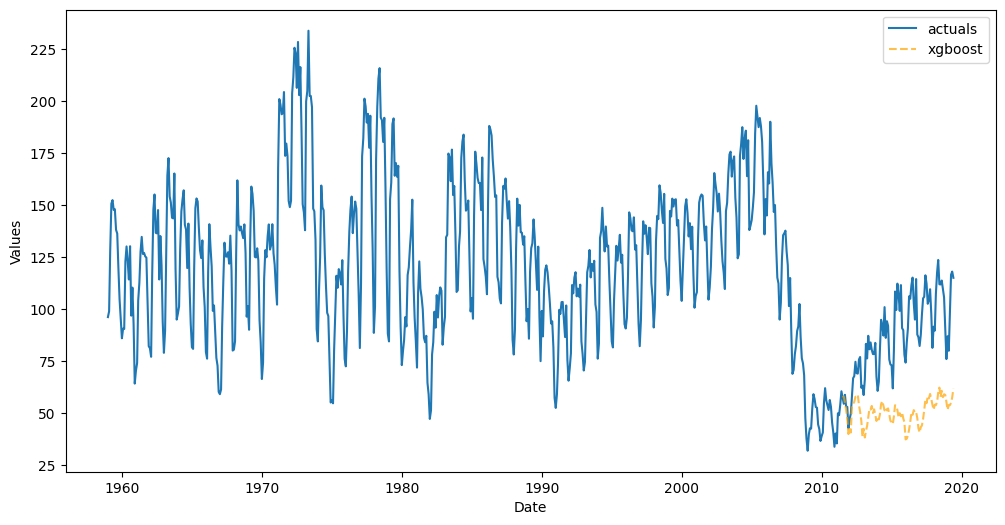

In [11]:
f.plot_test_set()

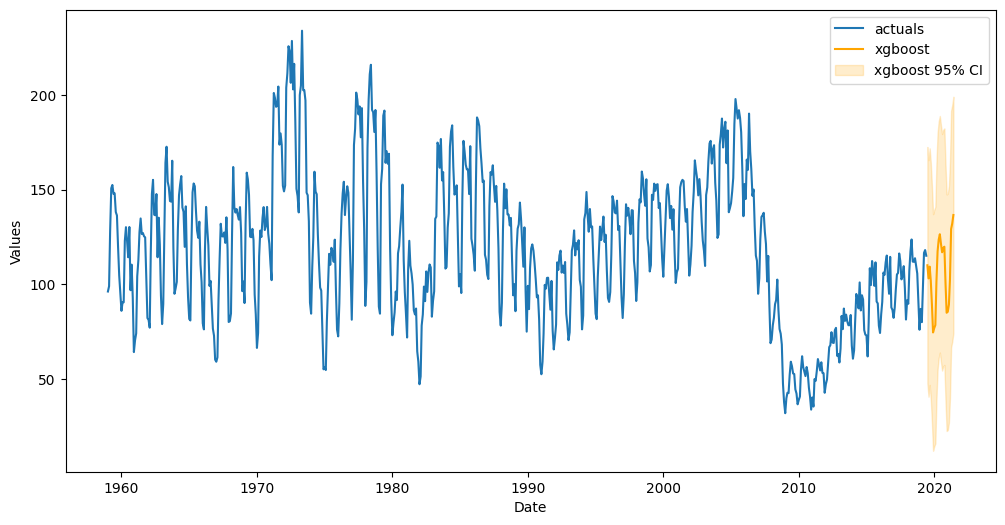

In [12]:
f.plot(ci=True)
plt.show()

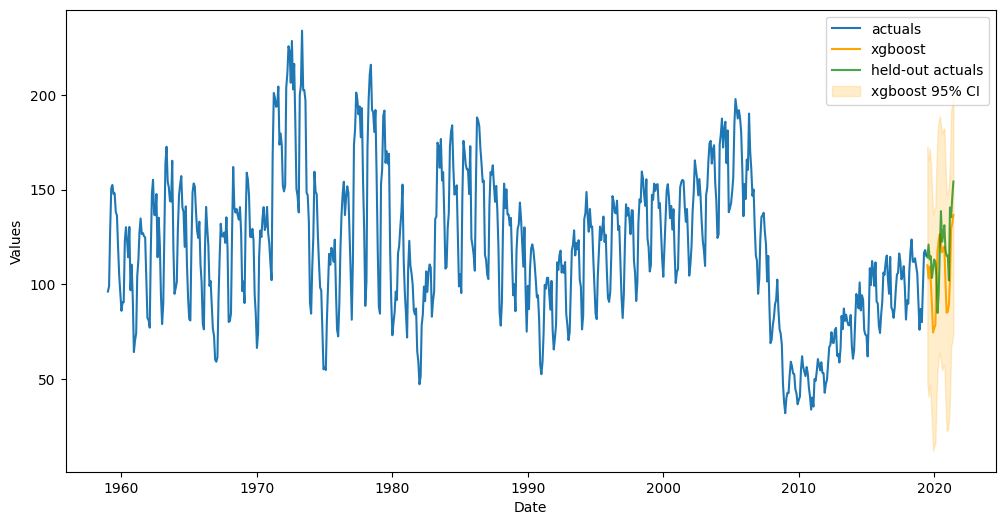

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [14]:
metrics.msis(
    a = starts_sep,
    uf = f.history['xgboost']['UpperCI'],
    lf = f.history['xgboost']['LowerCI'],
    obs = f.y,
    m = 12,
)

6.800672494172905

In [15]:
backtest_results = backtest_for_resid_matrix(f,pipeline=pipeline)
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix)

<AxesSubplot:xlabel='Date', ylabel='Values'>

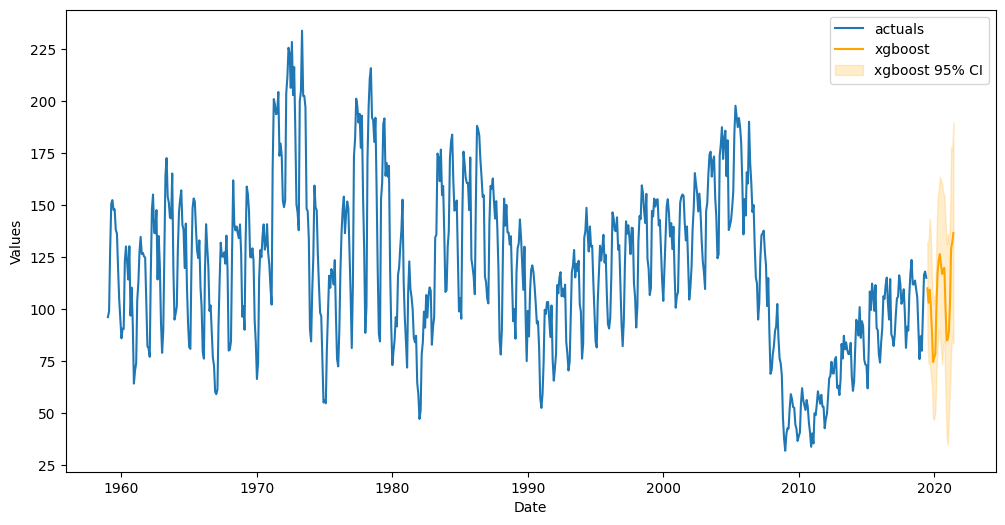

In [16]:
f.plot(ci=True)

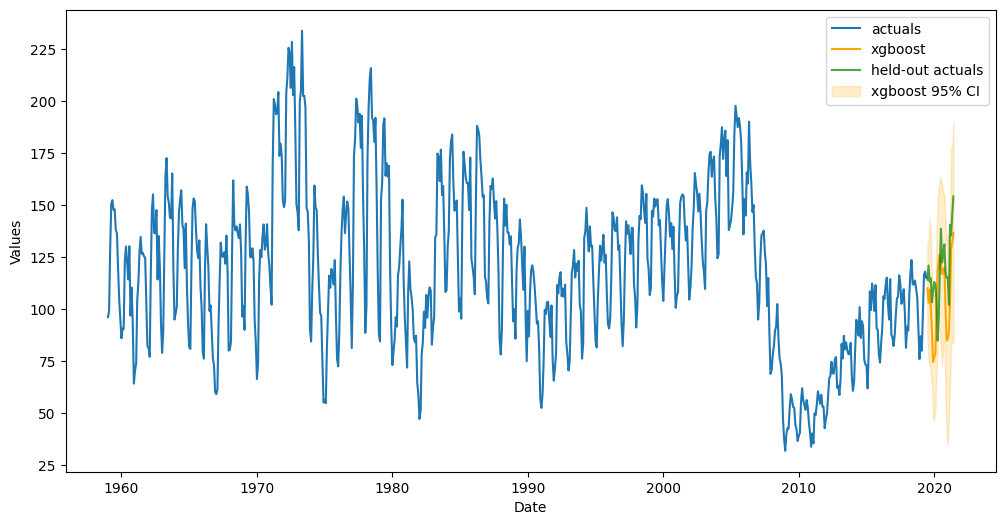

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [18]:
metrics.msis(
    a = starts_sep,
    uf = f.history['xgboost']['UpperCI'],
    lf = f.history['xgboost']['LowerCI'],
    obs = f.y,
    m = 12,
)

5.707450033378745

In [19]:
backtest_metrics(backtest_results,mets=['rmse','r2','bias'])[['Average']]

Average
Model   Metric           
xgboost rmse    19.091386
        r2      -1.996011
        bias   -85.787697